<a href="https://colab.research.google.com/github/Bipin-6751/Machine-Learning-Collection/blob/master/dogvscat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Building

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import keras



In [2]:
base_model = InceptionV3(input_shape=(256, 256, 3), include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [44]:
for layer in base_model.layers:
  layer.trainable = False

In [55]:
x = Flatten()(base_model.output)
x = Dense(units=2, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

Pre-Processing using datagenerator

In [56]:
train_datagen = ImageDataGenerator(featurewise_center=True, 
                                   rotation_range=0.4,
                                   width_shift_range=0.3,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input,
                                   vertical_flip=True,
                                   zoom_range=0.4,
                                   shear_range=0.4)

In [57]:
train_data = train_datagen.flow_from_directory(directory="/content/Dataset", 
                                               target_size=(256,256),
                                               batch_size=36)

Found 25000 images belonging to 2 classes.


In [58]:
train_data.class_indices

{'cat': 0, 'dog': 1}

In [59]:
t_image, label = train_data.next()

In [60]:
def plotImages(img_arr, label):
  for idx, img in enumerate(img_arr):
    if idx <=10:
      plt.figure(figsize=(5,5))
      plt.imshow(img)
      plt.title(img.shape)
      plt.axis=False
      plt.show()



Model Checkpoint

In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="./best_model.h5",
                     monitor="accuracy",
                     verbose=1,
                     save_best_only=True)
es = EarlyStopping(monitor="accuracy",
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc, es]

In [62]:
from keras import callbacks
his = model.fit_generator(train_data,
                          steps_per_epoch=10,
                          epochs=10,
                          callbacks=cb)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 4.6745 - accuracy: 0.5944
Epoch 1: accuracy improved from -inf to 0.59444, saving model to ./best_model.h5
10/10 [==============================] - 13s 780ms/step - loss: 4.6745 - accuracy: 0.5944
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.4451 - accuracy: 0.8583
Epoch 2: accuracy improved from 0.59444 to 0.85833, saving model to ./best_model.h5
10/10 [==============================] - 9s 889ms/step - loss: 1.4451 - accuracy: 0.8583
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.9056
Epoch 3: accuracy improved from 0.85833 to 0.90556, saving model to ./best_model.h5
10/10 [==============================] - 8s 838ms/step - loss: 0.7893 - accuracy: 0.9056
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.9139
Epoch 4: accuracy improved from 0.90556 to 0.91389, saving model to ./best_model.h5
10/10 [================

In [63]:
from keras.models import load_model
model = load_model("/content/best_model.h5") 

In [64]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy'])

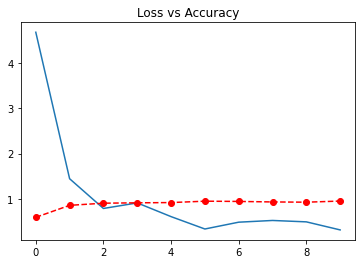

In [67]:
plt.plot(h['loss'])
plt.plot(h['accuracy'], 'go--', c='red')
plt.title("Loss vs Accuracy")
plt.show()

Validatr our image

The image is of cat


<function matplotlib.pyplot.show>

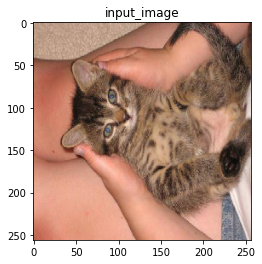

In [73]:
from keras.preprocessing import image
path ="/content/test1/6.jpg"

img = image.load_img(path, target_size=(256, 256))

i = image.img_to_array(img)
i = preprocess_input(i)
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

if pred == 0:
  print("The image is of cat")
else:
  print("The image is of dog")


plt.imshow(input_arr[0])
plt.title('input_image')
plt.show




Grad-CAM "gradiant class activation map 

In [75]:
def get_img_arr(img_path):
  path = img_path
  img = image.load_img(path, target_size=(256, 256))
  img = image.img_to_array(img)
  img = preprocess_input(img)

  img = np.array([img])
  return img

In [76]:
import tensorflow as tf

In [77]:
def make_gracam_heatmap(img_arr, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model(
      [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_arr)

    if pred_index is None:
      pred_index = tf.argmax(preds[0])

    class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)

  pooles_grads = tf.reduce_mean(grads, axis=(0,1,2))

  last_conv_layer_output = last_conv_layer_output[0]

  heatmap = last_conv_layer_output @ pooles_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0)/tf.math.reduce_max(heatmap)
  return heatmap.numpy()




Mask Heatmap on image

In [78]:
import matplotlib.cm as cm
from IPython.display import Image, display

In [84]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha=0.4):
  img = image.img_to_array(image.load_img(img_path))
  heatmap = np.uint8(255*heatmap)
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  superimposed_img.save(cam_path)

  display(Image(cam_path))







In [85]:
def image_prediction_and_visualization(path, last_conv_layer_name="conv2d_94", model=model):
  img_array = get_img_arr(path)

  heatmap = make_gracam_heatmap(img_array, model, last_conv_layer_name )

  plt.title("The heat map of the image is")
  plt.imshow(heatmap)
  plt.show()

  pred =  np.argmax(model.predict(preprocess_input(img_array)))
  print()
  print()
  print()

  if pred == 0:
    print("The image is of cat")
  else:
    print("The image is of dog")

  print()
  print()
  print()

  print("Image with heatmap representing region on interest")

  save_and_display_gradcam(path, heatmap)
  print()
  print("The original input image")
  print()

  a = plt.imread(path)
  plt.imshow(a, cmap='gray')
  plt.title("original image")
  plt.show()




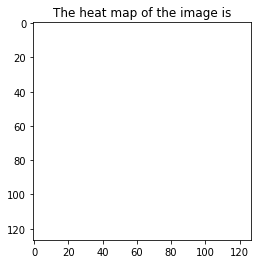




The image is of dog



Image with heatmap representing region on interest


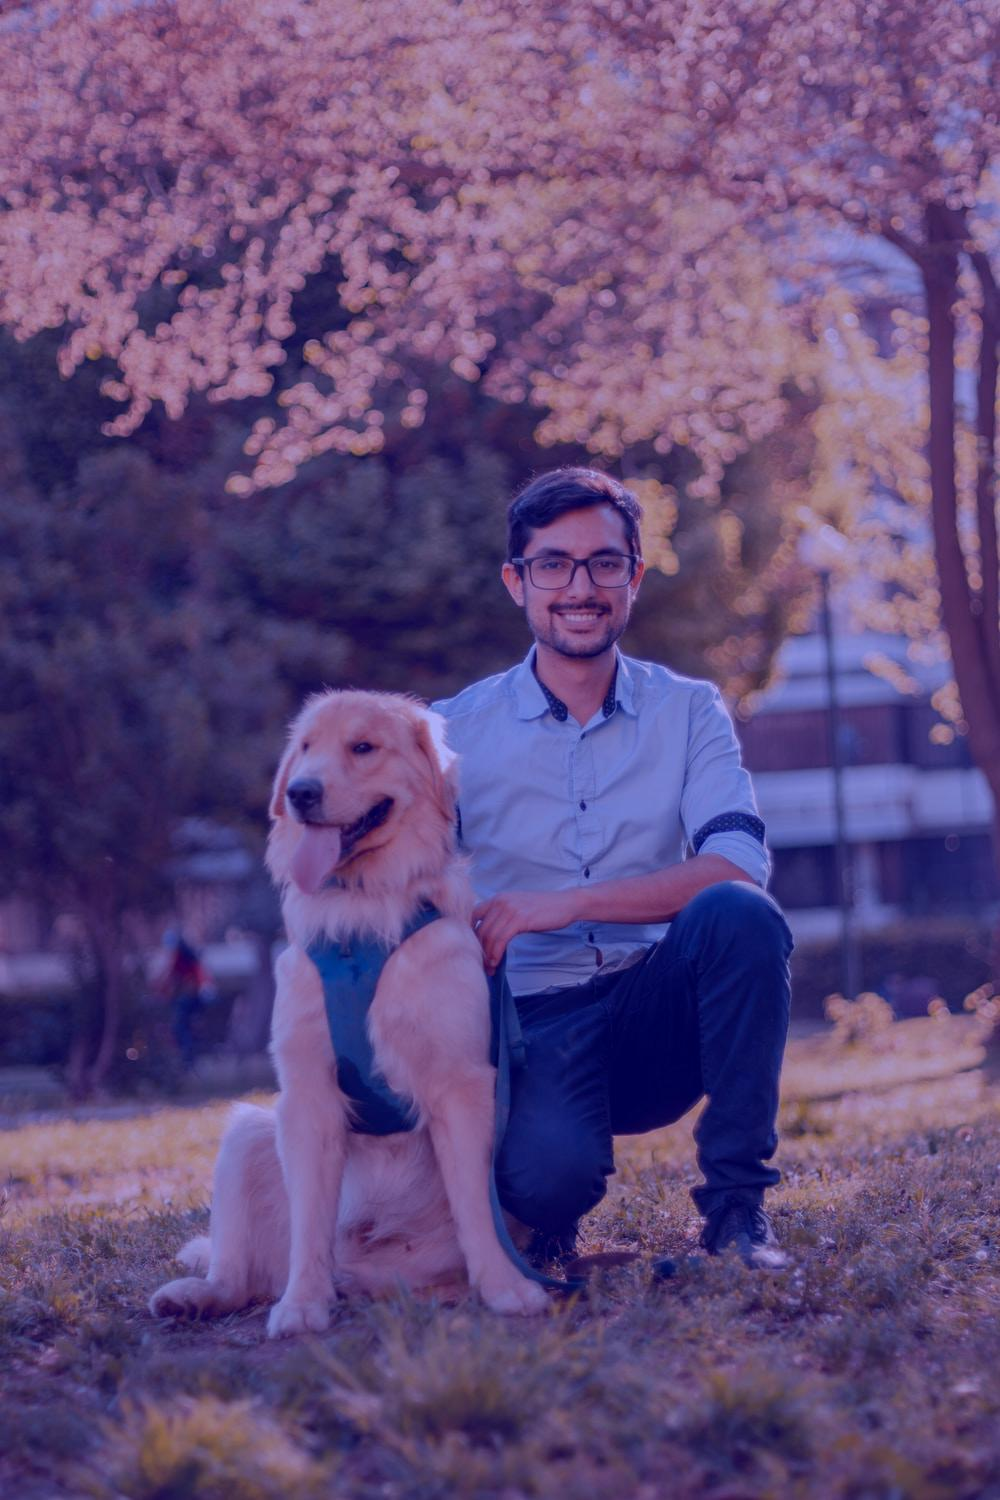


The original input image



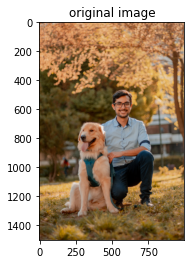

In [91]:
path = "/content/photo-1602900017944-678041f27dbc.jfif"
image_prediction_and_visualization(path)